### Настройка окружения

In [1]:
!pwd

/content


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd  drive/MyDrive/'Colab Notebooks'/Coloring-greyscale-images

/content/drive/MyDrive/Colab Notebooks/Coloring-greyscale-images


In [ ]:
!git pull origin alhpa-version

From https://github.com/Evgev/Coloring-greyscale-images
 * branch            alhpa-version -> FETCH_HEAD
Already up to date.


In [ ]:
!ls -a

Alpha-version  .git  .gitignore  .idea	LICENSE  README_images	README.md


In [ ]:
!git branch

* alhpa-version


### Альфа версия

In [ ]:
!pwd

/content/drive/MyDrive/Colab Notebooks/Coloring-greyscale-images


In [4]:
%cd Alpha-version/

/content/drive/MyDrive/Colab Notebooks/Coloring-greyscale-images/Alpha-version


In [ ]:
!pip install fiftyone openimages

_

In [ ]:
from tensorflow.keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf
import shutil  # Импортируем shutil для копирования файлов
import cv2


#### Создание обучающей выборки

In [ ]:
import fiftyone as fo
import fiftyone.zoo as foz

# Загружаем Open Images Dataset
dataset = foz.load_zoo_dataset("open-images-v6", max_samples=200)


In [ ]:

# Папка, куда будут сохраняться изображения
images_dir = os.path.join(os.getcwd(), "images")  # Путь к директории
os.makedirs(images_dir, exist_ok=True)  # Создаем директорию, если она не существует

# Перебираем образцы и копируем их изображения
for sample in dataset:
    image_path = sample.filepath  # Получаем путь к изображению
    output_path = os.path.join(images_dir, os.path.basename(image_path))  # Путь для сохранения

    # Копируем изображение в выходную директорию
    shutil.copy(image_path, output_path)  # Копирование изображения

In [ ]:

# Путь к папке с изображениями
images_list = []
desired_size = (400, 400)

# Проходим по всем файлам в директории
for filename in os.listdir(images_dir):
    if filename.endswith(".jpg"):  # Проверяем, что файл является изображением в формате JPG
        img_path = os.path.join(images_dir, filename)

        # Загружаем изображение
        image = cv2.imread(img_path)

        if (image is not None) and (image.shape[:2] > desired_size):  # Проверяем, что изображение успешно загружено
            image_resized = cv2.resize(image, desired_size)
            images_list.append(image_resized)


images_array = np.array(images_list, dtype=np.uint8)

# Проверяем размерности и тип массива
print("Shape of images_array:", images_array.shape)  # (количество изображений, высота, ширина, количество каналов)
print("Data type of images_array:", images_array.dtype)  # dtype будет uint8

Shape of images_array: (600, 400, 400, 3)
Data type of images_array: uint8


In [89]:
# Вывод всех изображений

# from google.colab.patches import cv2_imshow
# for image in images_array:
#   cv2_imshow( image)

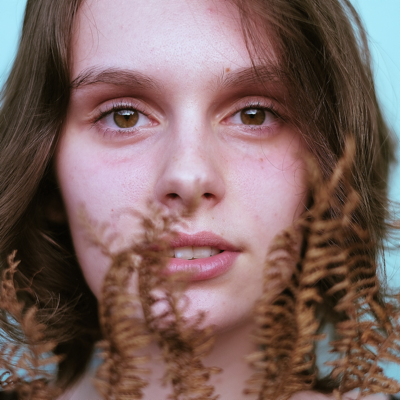

In [ ]:
load_img('woman.jpg')

In [ ]:
# Get images
image = img_to_array(load_img('woman.jpg'))
image = np.array(image, dtype=float)

In [ ]:
X = rgb2lab(1.0/255*image)[:,:,0]
Y = rgb2lab(1.0/255*image)[:,:,1:]


array([[87, 87, 87, ..., 88, 88, 87],
       [87, 87, 87, ..., 88, 87, 88],
       [87, 88, 87, ..., 87, 87, 87],
       ...,
       [ 3,  3,  4, ..., 36, 39, 41],
       [ 3,  3,  4, ..., 28, 31, 32],
       [ 2,  3,  4, ..., 15, 23, 23]], dtype=uint8)
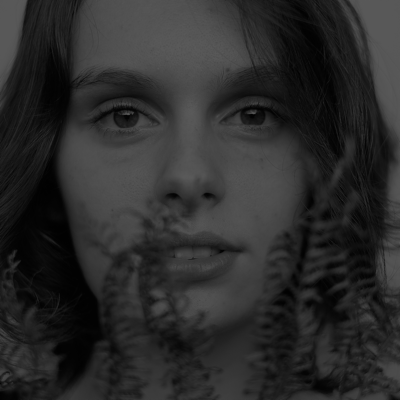

In [ ]:
X.astype(np.uint8)

In [ ]:
Y /= 128
X = X.reshape(1, 400, 400, 1)
Y = Y.reshape(1, 400, 400, 2)

In [ ]:
X.shape

(1, 400, 400, 1)

In [ ]:
# Building the neural network
model = Sequential()
model.add(InputLayer(input_shape=(None, None, 1)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
model.layers

[<Conv2D name=conv2d, built=True>,
 <Conv2D name=conv2d_1, built=True>,
 <Conv2D name=conv2d_2, built=True>,
 <Conv2D name=conv2d_3, built=True>,
 <Conv2D name=conv2d_4, built=True>,
 <Conv2D name=conv2d_5, built=True>,
 <UpSampling2D name=up_sampling2d, built=True>,
 <Conv2D name=conv2d_6, built=True>,
 <UpSampling2D name=up_sampling2d_1, built=True>,
 <Conv2D name=conv2d_7, built=True>,
 <UpSampling2D name=up_sampling2d_2, built=True>,
 <Conv2D name=conv2d_8, built=True>]

In [ ]:
# Finish model
model.compile(optimizer='rmsprop',loss='mse')

In [ ]:
model.fit(x=X,
    y=Y,
    batch_size=1,
    epochs=100)

In [ ]:

print(model.evaluate(X, Y, batch_size=1))
output = model.predict(X)
output *= 128
# Output colorizations
cur = np.zeros((400, 400, 3))
cur[:,:,0] = X[0][:,:,0]
cur[:,:,1:] = output[0]

cur_rgb = (lab2rgb(cur) * 255).astype(np.uint8)
imsave("img_result.png", cur_rgb)
cur_rgb

### Проверка на изображениях, не участвующих в обучении

In [ ]:
image = img_to_array(load_img('man.jpg'))
image = np.array(image, dtype=float)
X = rgb2lab(1.0/255*image)[:,:,0]


In [ ]:
X.astype(np.uint8)

In [ ]:
# Предсказанное значение
X = X.reshape(1, 400, 400, 1)
tatget = model.predict(X)
tatget *= 128
# Output colorizations
cur = np.zeros((400, 400, 3))
cur[:,:,0] = X[0][:,:,0]
cur[:,:,1:] = output[0]

cur_rgb = (lab2rgb(cur) * 255).astype(np.uint8)
cur_rgb

In [ ]:
# Оригинал
image.astype(np.uint8)

### Сохраниение

In [16]:
!git add alpha_version_notebook.ipynb

In [17]:
!git config --global user.email "evgeny_skr@mail.ru"
!git config --global user.name "Evgev"

In [14]:
!git commit -m "Добавил датасет изображений для обучения модели"

[alhpa-version bea7059] Добавил датасет изображений для обучения модели
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite Alpha-version/alpha_version_notebook.ipynb (93%)


In [7]:
!git log

commit fe81e612b8c8af77815809cc0187ea2c2815f36a (HEAD -> alhpa-version)
Author: Evgev <evgeny_skr@mail.ru>
Date:   Sat Nov 23 18:37:52 2024 +0000

    Добавил датасет изображений для обучения модели

commit fb18f3dc8829cdf39a597f964b069d0a09322060
Author: Evgev <evgeny_skr@mail.ru>
Date:   Sat Nov 23 14:04:49 2024 +0000

    Добавил тестирование на изображениях, не из обучающей выборки

commit 23b43e3a104555b7b6adaabc0d98a6fe0f5dfd7e (origin/alhpa-version, origin/HEAD)
Author: root <root@Iphone.>
Date:   Sat Nov 23 12:05:23 2024 +0300

    add alpha-version

commit d9a4762fdf648f7254a3e7461b2d2c9afc6b0699
Author: root <root@Iphone.>
Date:   Sat Nov 23 11:51:30 2024 +0300

    add Alpha-version


In [6]:
!git rev-list --objects --all | grep fe81e612b8c8af77815809cc0187ea2c2815f36a

fe81e612b8c8af77815809cc0187ea2c2815f36a


In [15]:
!git reset

Unstaged changes after reset:
M	Alpha-version/alpha_version_notebook.ipynb


In [10]:
!git reset --soft fb18f3dc8829cdf39a597f964b069d0a09322060
